Code to accompany Machine Learning Recipes #8. We'll write a Decision Tree Classifier, in pure Python. Below each of the methods, I've written a little demo to help explain what it does.

* CART (Classification and Regression Tree)
Each Node will ask a T/F question about one of the features and splits the dataset accordingly. 
We continue down the tree to split the data into nodes that are 'as pure as possible'. 

### Which Questions to ask and When?
Look at something like Information Gain for each class node and Gini Impurity of each separated set of data. 

#### Impurity
If you split the data into feature and label, randomly draw one point from each, the impurity is the chance that you got a wrong match. E.g. if you draw from a bowl of apples and a bowl with only apple labels, your impurity will be 0. 

BUT if you draw from a bowl that is mixed fruits and mixed labels, the impurity will be higher.
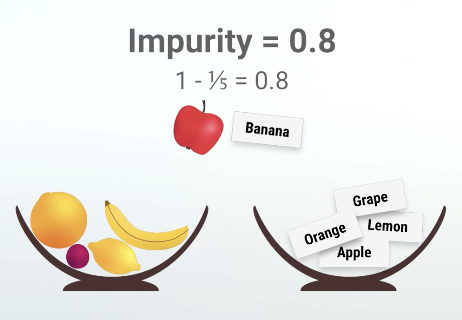

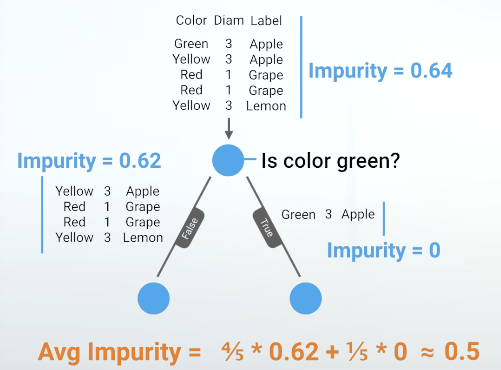
> Information gain = impurity of previous node - impurity of child nodes <br>
                 = 0.64 - average impurity = 0.64 - 0.5 = 0.14

In [1]:
# For Python 2 / 3 compatability
from __future__ import print_function

In [2]:
# Toy dataset.
# Format: each row is an example.
# The last column is the label.
# The first two columns are features.
# Feel free to play with it by adding more features & examples.
# Interesting note: I've written this so the 2nd and 5th examples
# have the same features, but different labels - so we can see how the
# tree handles this case.
training_data = [
    ['Green', 3, 'Apple'],
    ['Yellow', 3, 'Apple'],
    ['Red', 1, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
] 
# Note that there are rows with the same features but different Labels (e.g. row 2 and 5)

In [3]:
# Column labels.
# These are used only to print the tree.
header = ["color", "diameter", "label"]

In [4]:
training_data

[['Green', 3, 'Apple'],
 ['Yellow', 3, 'Apple'],
 ['Red', 1, 'Grape'],
 ['Red', 1, 'Grape'],
 ['Yellow', 3, 'Lemon']]

In [7]:
def unique_vals(rows, col):
    """Find the unique values for a column in a dataset."""
    return set([row[col] for row in rows])

In [8]:
#######
# Demo:
unique_vals(training_data, 0)
# unique_vals(training_data, 1)
#######

{'Green', 'Red', 'Yellow'}

In [9]:
def class_counts(rows):
    """Counts the number of each type of example in a dataset."""
    counts = {}  # a dictionary of label -> count.
    for row in rows:
        # in our dataset format, the label is always the last column
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [10]:
#######
# Demo:
class_counts(training_data)
#######

{'Apple': 2, 'Grape': 2, 'Lemon': 1}

In [11]:
def is_numeric(value):
    """Test if a value is numeric."""
    return isinstance(value, int) or isinstance(value, float)

In [12]:
#######
# Demo:
is_numeric(7)
# is_numeric("Red")
#######

True

In [13]:
class Question:
    """A Question is used to partition a dataset.

    This class just records a 'column number' (e.g., 0 for Color) and a
    'column value' (e.g., Green). The 'match' method is used to compare
    the feature value in an example to the feature value stored in the
    question. See the demo below.
    """

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (
            header[self.column], condition, str(self.value))

In [14]:
#######
# Demo:
# Let's write a question for a numeric attribute
Question(1, 3)

Is diameter >= 3?

In [15]:
# How about one for a categorical attribute
q = Question(0, 'Green')
q

Is color == Green?

In [16]:
# Let's pick an example from the training set...
example = training_data[0]
# ... and see if it matches the question
q.match(example) # this will be true, since the first example is Green.
#######

True

In [17]:
def partition(rows, question):
    """Partitions a dataset.

    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [18]:
#######
# Demo:
# Let's partition the training data based on whether rows are Red.
true_rows, false_rows = partition(training_data, Question(0, 'Red'))
# This will contain all the 'Red' rows.
true_rows

[['Red', 1, 'Grape'], ['Red', 1, 'Grape']]

In [19]:
# This will contain everything else.
false_rows
#######

[['Green', 3, 'Apple'], ['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']]

In [20]:
def gini(rows):
    """Calculate the Gini Impurity for a list of rows.

    There are a few different ways to do this, I thought this one was
    the most concise. See:
    https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity
    """
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

In [21]:
#######
# Demo:
# Let's look at some example to understand how Gini Impurity works.
#
# First, we'll look at a dataset with no mixing.
no_mixing = [['Apple'],
              ['Apple']]
# this will return 0
gini(no_mixing)

0.0

In [22]:
# Now, we'll look at dataset with a 50:50 apples:oranges ratio
some_mixing = [['Apple'],
               ['Orange']]
# this will return 0.5 - meaning, there's a 50% chance of misclassifying
# a random example we draw from the dataset.
gini(some_mixing)

0.5

In [20]:
# Now, we'll look at a dataset with many different labels
lots_of_mixing = [['Apple'],
                  ['Orange'],
                  ['Grape'],
                  ['Grapefruit'],
                  ['Blueberry']]
# This will return 0.8
gini(lots_of_mixing)
#######

0.7999999999999998

In [23]:
def info_gain(left, right, current_uncertainty):
    """Information Gain.

    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.
    """
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [24]:
#######
# Demo:
# Calculate the uncertainy of our training data.
current_uncertainty = gini(training_data)
current_uncertainty

0.6399999999999999

In [25]:
# How much information do we gain by partioning on 'Green'?
true_rows, false_rows = partition(training_data, Question(0, 'Green'))
info_gain(true_rows, false_rows, current_uncertainty)

0.1399999999999999

In [26]:
# What about if we partioned on 'Red' instead?
true_rows, false_rows = partition(training_data, Question(0,'Red'))
info_gain(true_rows, false_rows, current_uncertainty)

0.37333333333333324

In [27]:
# It looks like we learned more using 'Red' (0.37), than 'Green' (0.14).
# Why? Look at the different splits that result, and see which one
# looks more 'unmixed' to you.
true_rows, false_rows = partition(training_data, Question(0,'Red'))

# Here, the true_rows contain only 'Grapes'.
true_rows

[['Red', 1, 'Grape'], ['Red', 1, 'Grape']]

In [26]:
# And the false rows contain two types of fruit. Not too bad.
false_rows

[['Green', 3, 'Apple'], ['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']]

In [28]:
# On the other hand, partitioning by Green doesn't help so much.
true_rows, false_rows = partition(training_data, Question(0,'Green'))

# We've isolated one apple in the true rows.
true_rows

[['Green', 3, 'Apple']]

In [29]:
# But, the false-rows are badly mixed up.
false_rows
#######

[['Yellow', 3, 'Apple'],
 ['Red', 1, 'Grape'],
 ['Red', 1, 'Grape'],
 ['Yellow', 3, 'Lemon']]

In [31]:
def find_best_split(rows):
    """Find the best question to ask by iterating over every feature / value
    and calculating the information gain."""
    best_gain = 0  # keep track of the best information gain
    best_question = None  # keep train of the feature / value that produced it
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1  # number of columns

    for col in range(n_features):  # for each feature

        values = set([row[col] for row in rows])  # unique values in the column

        for val in values:  # for each value

            question = Question(col, val)

            # try splitting the dataset
            true_rows, false_rows = partition(rows, question)

            # Skip this split if it doesn't divide the
            # dataset. (Discard the question if it fails to produce a split)
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = info_gain(true_rows, false_rows, current_uncertainty)

            # You actually can use '>' instead of '>=' here
            # but I wanted the tree to look a certain way for our
            # toy dataset.
            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [32]:
#######
# Demo:
# Find the best question to ask first for our toy dataset.
best_gain, best_question = find_best_split(training_data)
best_question
# FYI: is color == Red is just as good. See the note in the code above
# where I used '>='.
#######

Is diameter >= 3?

In [33]:
class Leaf:
    """A Leaf node classifies data.

    This holds a dictionary of class (e.g., "Apple") -> number of times
    it appears in the rows from the training data that reach this leaf.
    """

    def __init__(self, rows):
        self.predictions = class_counts(rows)

In [34]:
class Decision_Node:
    """A Decision Node asks a question.

    This holds a reference to the question, and to the two child nodes.
    """

    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [35]:
def build_tree(rows):
    """Builds the tree.

    Rules of recursion: 1) Believe that it works. 2) Start by checking
    for the base case (no further information gain). 3) Prepare for
    giant stack traces.
    """

    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    gain, question = find_best_split(rows)

    # Base case: no further info gain
    # Since we can ask no further questions,
    # we'll return a leaf. (end of the branch)
    if gain == 0:
        return Leaf(rows)

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)

    # Recursively build the true branch.
    true_branch = build_tree(true_rows)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows)

    # Return a Question node.
    # This records the best feature / value to ask at this point,
    # as well as the branches to follow
    # dependingo on the answer.
    return Decision_Node(question, true_branch, false_branch)

In [36]:
def print_tree(node, spacing=""):
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [37]:
# to build the tree: Input is our entire training set. 
#Output is reference to the root node of the tree
my_tree = build_tree(training_data)

In [38]:
print_tree(my_tree)

Is diameter >= 3?
--> True:
  Is color == Yellow?
  --> True:
    Predict {'Apple': 1, 'Lemon': 1}
  --> False:
    Predict {'Apple': 1}
--> False:
  Predict {'Grape': 2}


In [39]:
def classify(row, node):
    """See the 'rules of recursion' above."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions

    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node,
    # to the example we're considering.
    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [40]:
#######
# Demo:
# The tree predicts the 1st row of our
# training data is an apple with confidence 1.
classify(training_data[0], my_tree)
#######

{'Apple': 1}

In [41]:
def print_leaf(counts):
    """A nicer way to print the predictions at a leaf."""
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [42]:
#######
# Demo:
# Printing that a bit nicer
print_leaf(classify(training_data[0], my_tree))
#######

{'Apple': '100%'}

In [43]:
#######
# Demo:
# On the second example, the confidence is lower
print_leaf(classify(training_data[1], my_tree))
#######

{'Apple': '50%', 'Lemon': '50%'}

In [44]:
# Evaluate
testing_data = [
    ['Green', 3, 'Apple'],
    ['Yellow', 4, 'Apple'],
    ['Red', 2, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
]

In [45]:
for row in testing_data:
    print ("Actual: %s. Predicted: %s" %
           (row[-1], print_leaf(classify(row, my_tree))))

Actual: Apple. Predicted: {'Apple': '100%'}
Actual: Apple. Predicted: {'Apple': '50%', 'Lemon': '50%'}
Actual: Grape. Predicted: {'Grape': '100%'}
Actual: Grape. Predicted: {'Grape': '100%'}
Actual: Lemon. Predicted: {'Apple': '50%', 'Lemon': '50%'}
